In this notebook, we have a dataset whose purpose is to predict when earthquakes will take place. Specifically, the dataset is meant to be used to predict the time remaining before laboratory earthquakes occur based on real-time seismic data. Before we can make any predictions, it's always important to become familiar with your data and carry out Exploratory Data Analysis. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from os import listdir
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

To begin, we'll load in our data and take a look at the first five rows.

In [2]:
train = pd.read_csv('/Users/anthonybransford/Downloads/LANL-Earthquake-Prediction/train.csv', nrows=10000000, 
                    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
train.head(5)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


We can see that our data only has two columns: 'acoustic_data' and 'time_to_failure'. The 'acoustic_data' represents our seismic singal while 'time_to_failure' corresponds to the time until the laboratory earthquake takes place. 

I decided to rename our columns, simply to make them easier to keep track of as well as reference.

In [3]:
train.rename({"acoustic_data": "signal", "time_to_failure": "quaketime"}, axis="columns", inplace=True)
train.head(5)

,signal,quaketime
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


Quaketime seems to be the same regardless of the signal. We should investigate further to verify whether or not there are differences in quaketime among the various signals. 

In [4]:
for n in range(5):
    print(train.quaketime.values[n])

1.4690999832
1.4690999821000001
1.4690999809999998
1.4690999799000002
1.4690999787999999


We can see that the quaketimes are actually not the same and that pandas has rounded off the times. After taking a quick look at the numbers above we can see that the quaketimes seem to decrease. I decided to plot these quaketimes in hopes of unveiling a pattern:

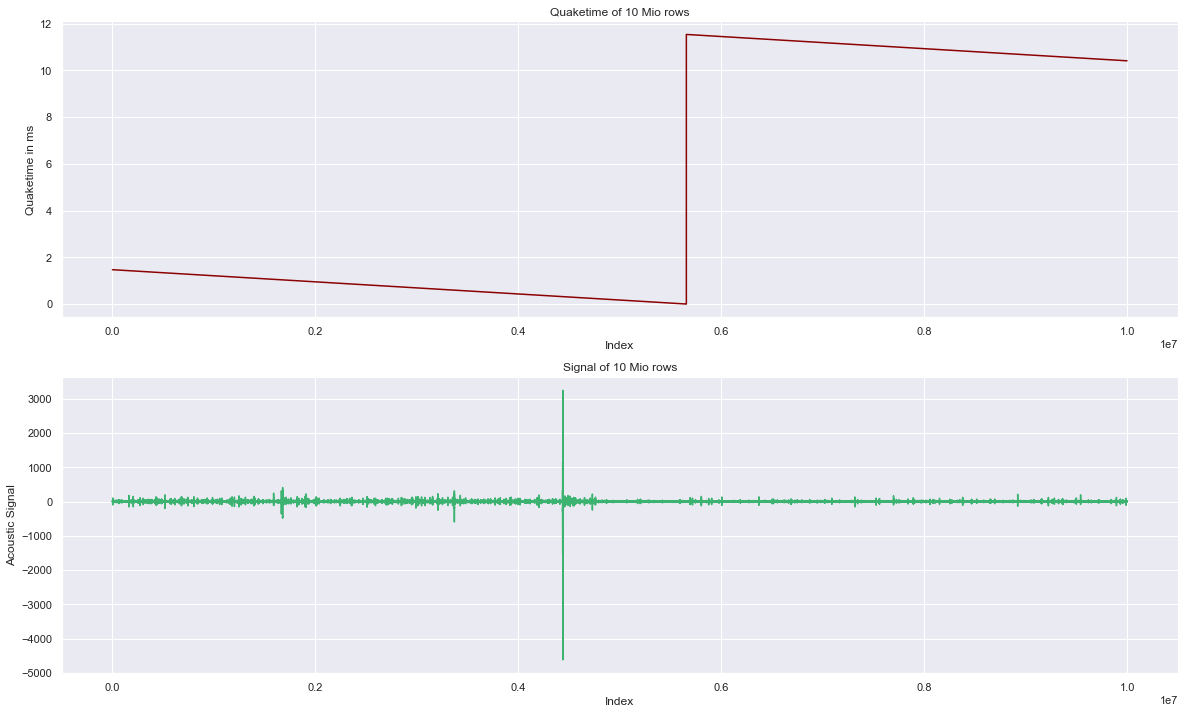

In [5]:
fig, ax = plt.subplots(2,1, figsize=(20,12))
ax[0].plot(train.index.values, train.quaketime.values, c="darkred")
ax[0].set_title("Quaketime of 10 Mio rows")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Quaketime in ms");
ax[1].plot(train.index.values, train.signal.values, c="mediumseagreen")
ax[1].set_title("Signal of 10 Mio rows")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Acoustic Signal");

We can see only one time in 10 Mio rows when quaketime goes to 0. This is a timepoint where an earthquake in the lab occurs.

There are many small oscillations until a heavy peak of the signal occurs. Then, it takes some time with smaller oscillations and the earthquake occurs.

If we take a look at the first 50,000 indices we can see that there is a second pattern of quaketime that may have something to do with the resolution of the experimental equipment:

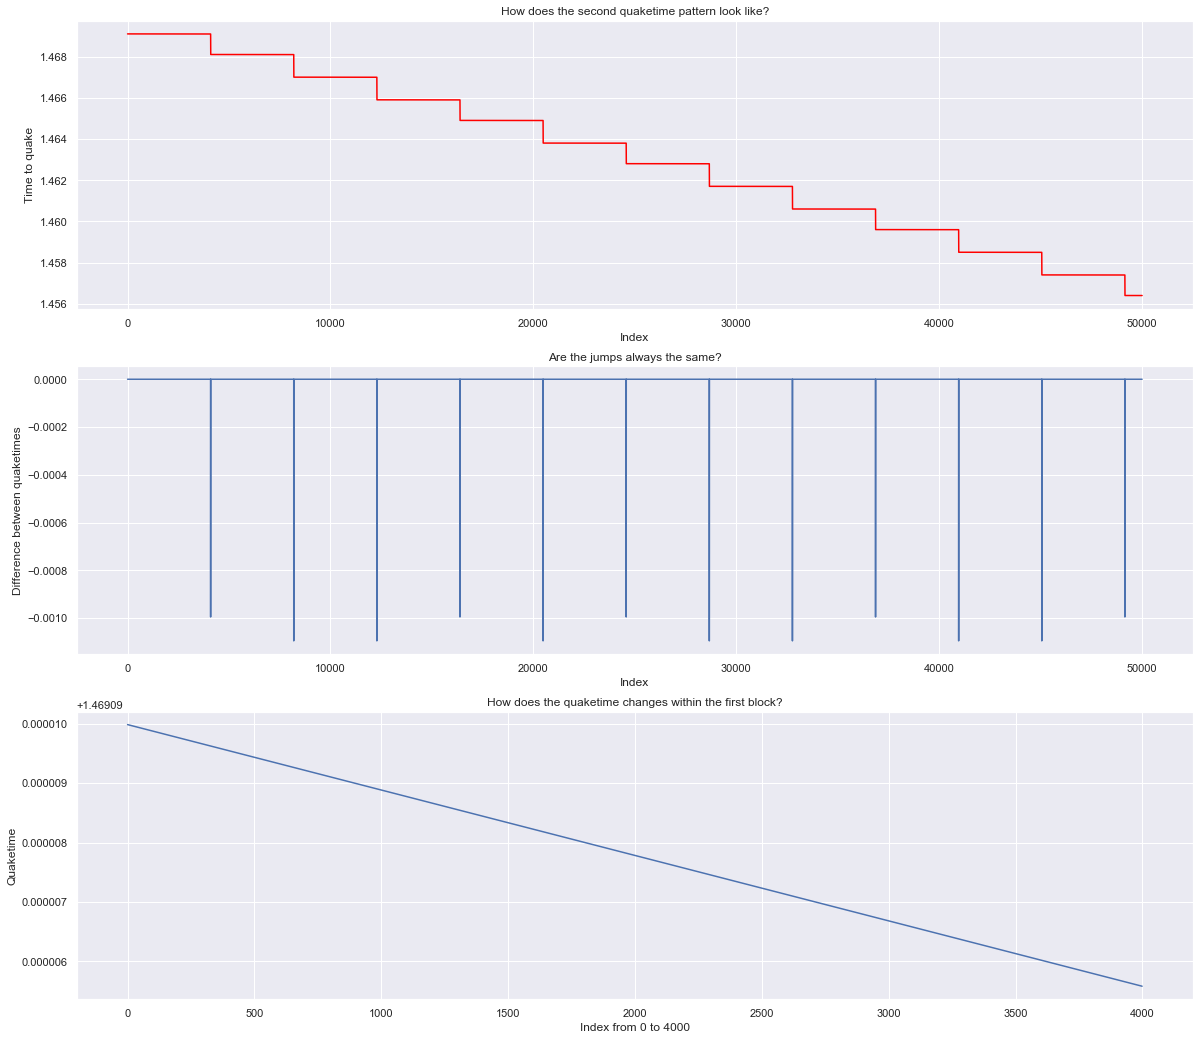

In [6]:
fig, ax = plt.subplots(3,1,figsize=(20,18))
ax[0].plot(train.index.values[0:50000], train.quaketime.values[0:50000], c="Red")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Time to quake")
ax[0].set_title("How does the second quaketime pattern look like?")
ax[1].plot(train.index.values[0:49999], np.diff(train.quaketime.values[0:50000]))
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Difference between quaketimes")
ax[1].set_title("Are the jumps always the same?")
ax[2].plot(train.index.values[0:4000], train.quaketime.values[0:4000])
ax[2].set_xlabel("Index from 0 to 4000")
ax[2].set_ylabel("Quaketime")
ax[2].set_title("How does the quaketime changes within the first block?");

The first plot shows that the quaketime seems to stay almost constant up to index 4,000. Then a steep decrease occurs. Afterwards this kind of pattern is repeated.

The second plot reveals that the second jump of the quaketime is larger than the first.

The third plot shows that the quaketime within such a "constant" block is not really constant but linearly decreasing even with very small numbers.

Even though there is only one signal feature and one target column, a few questions came to mind after taking an initial look at our training dataset. For starters, why do we have these low resolution jumps and why are they different? Is there some periodicity that may correlate with the signal? Would it be helpful to reconstruct that for our test segments?

For now, I'd like to further explore our training set. 

In [16]:
train.describe()

,signal,quaketime
count,1.000000e+07,1.000000e+07
mean,4.502072e+00,5.183598e+00
std,1.780707e+01,5.091286e+00
min,-4.621000e+03,7.954798e-04
25%,2.000000e+00,6.498971e-01
50%,4.000000e+00,1.298899e+00
75%,7.000000e+00,1.089170e+01
max,3.252000e+03,1.154080e+01


Here we see two things: We can see that the mean is shifted towards higher values due to the earthquake. In addition we can see that the 25% up to 75% quartiles are looking very discrete. Also, we can't say much about the numbers that we see under the quaketime column. 

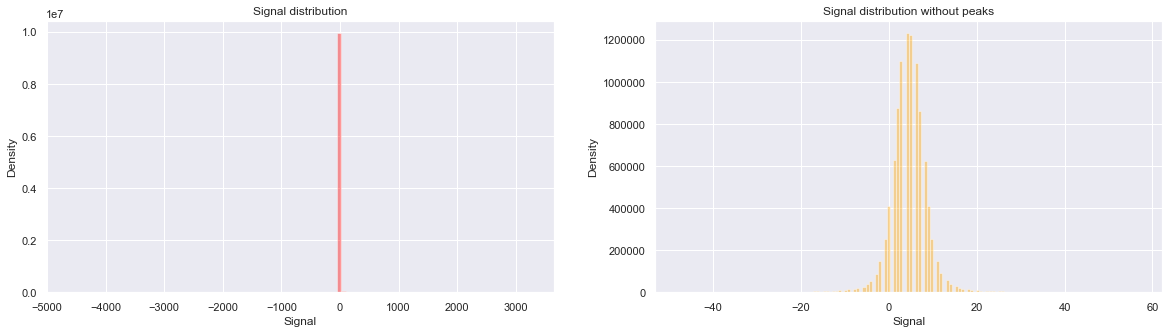

In [17]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(train.signal.values, ax=ax[0], color="Red", bins=100, kde=False)
ax[0].set_xlabel("Signal")
ax[0].set_ylabel("Density")
ax[0].set_title("Signal distribution")

low = train.signal.mean() - 3 * train.signal.std()
high = train.signal.mean() + 3 * train.signal.std() 
sns.distplot(train.loc[(train.signal >= low) & (train.signal <= high), "signal"].values,
             ax=ax[1],
             color="Orange",
             bins=150, kde=False)
ax[1].set_xlabel("Signal")
ax[1].set_ylabel("Density")
ax[1].set_title("Signal distribution without peaks");

In the first (red) plot, we can see that the earthquake causes very high outlier values.

The second plot shows the signal at the median and mean around 4. We can see that it looks very gaussian and balanced. It seems that the signal is somehow discrete.

Next, by computing the difference between quaketimes we obtain some kind of stepsize that is probably equal within blocks and can show us the jump strength between different quaketimes. The following code computes differences first and drops the last row of our training set such that we can add the stepsize to the data.

In [18]:
stepsize = np.diff(train.quaketime)
train = train.drop(train.index[len(train)-1])
train["stepsize"] = stepsize
train.head(5)

,signal,quaketime,stepsize
0,12,1.4691,-1.100000e-09
1,6,1.4691,-1.100000e-09
2,8,1.4691,-1.100000e-09
3,5,1.4691,-1.100000e-09
4,8,1.4691,-1.100000e-09


In [19]:
train.stepsize = train.stepsize.apply(lambda l: np.round(l, 10))

In [20]:
stepsize_counts = train.stepsize.value_counts()
stepsize_counts

-1.100000e-09    5655193
-1.000000e-09    3907598
-2.000000e-09     434767
-1.095496e-03        882
-1.095495e-03        679
-9.954955e-04        497
-9.954950e-04        381
-1.095497e-03          1
 1.154000e+01          1
Name: stepsize, dtype: int64

The stepsize within two quaketimes is often given by either -1, 1 or -2 ns. In addition we have stepsizes close to -1,0955 ms or -0,9955 ms. There's something centered at -1 ms. As we have one earthquake in our training set, a heavy stepsize of 11.5 is the step between the earthquake and a new cycle, which goes on until the next earthquake occurs.

In my opinion, it does not make sense to split the rows of the training data randomly to obtain validation data. This is temporal data and in the test segments we probably don't have any future values given. 

When it comes to a validation strategy, I realized that we needed a model that would be able to capture the temporal dependence of cycles and one that would be able to make nice predictions for different cycles. Since we need to make predictions for several different cycle-phases, it could be fruitful to use some kind of rolling window validation. 

One thing that I noticed about the test set was that it does not contain any earthquakes. As a result, I don't believe it would be a good idea to include them during training and validation. In training, they would cause extreme target outliers of quaketime. Our model may always try to match its predictions with these targets and this would hinder learning for the relevent parts, for those kind of predictions we need for the test set.

In [21]:
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=5)

At this point, I decided to further explore using features extracted by a rolling window approach. I wanted to create some visualisations displaying what goes on with these features until the first lab earthquake occurs.

I wasn't sure what window size would've been an appropriate choice and I felt it was a hyperparameter I should try to optimize. To start, I simply tried out some different sizes, including the mean and standard deviation, in order to select one that may be sufficient:

In [22]:
window_sizes = [10, 50, 100, 1000]
for window in window_sizes:
    train["rolling_mean_" + str(window)] = train.signal.rolling(window=window).mean()
    train["rolling_std_" + str(window)] = train.signal.rolling(window=window).std()

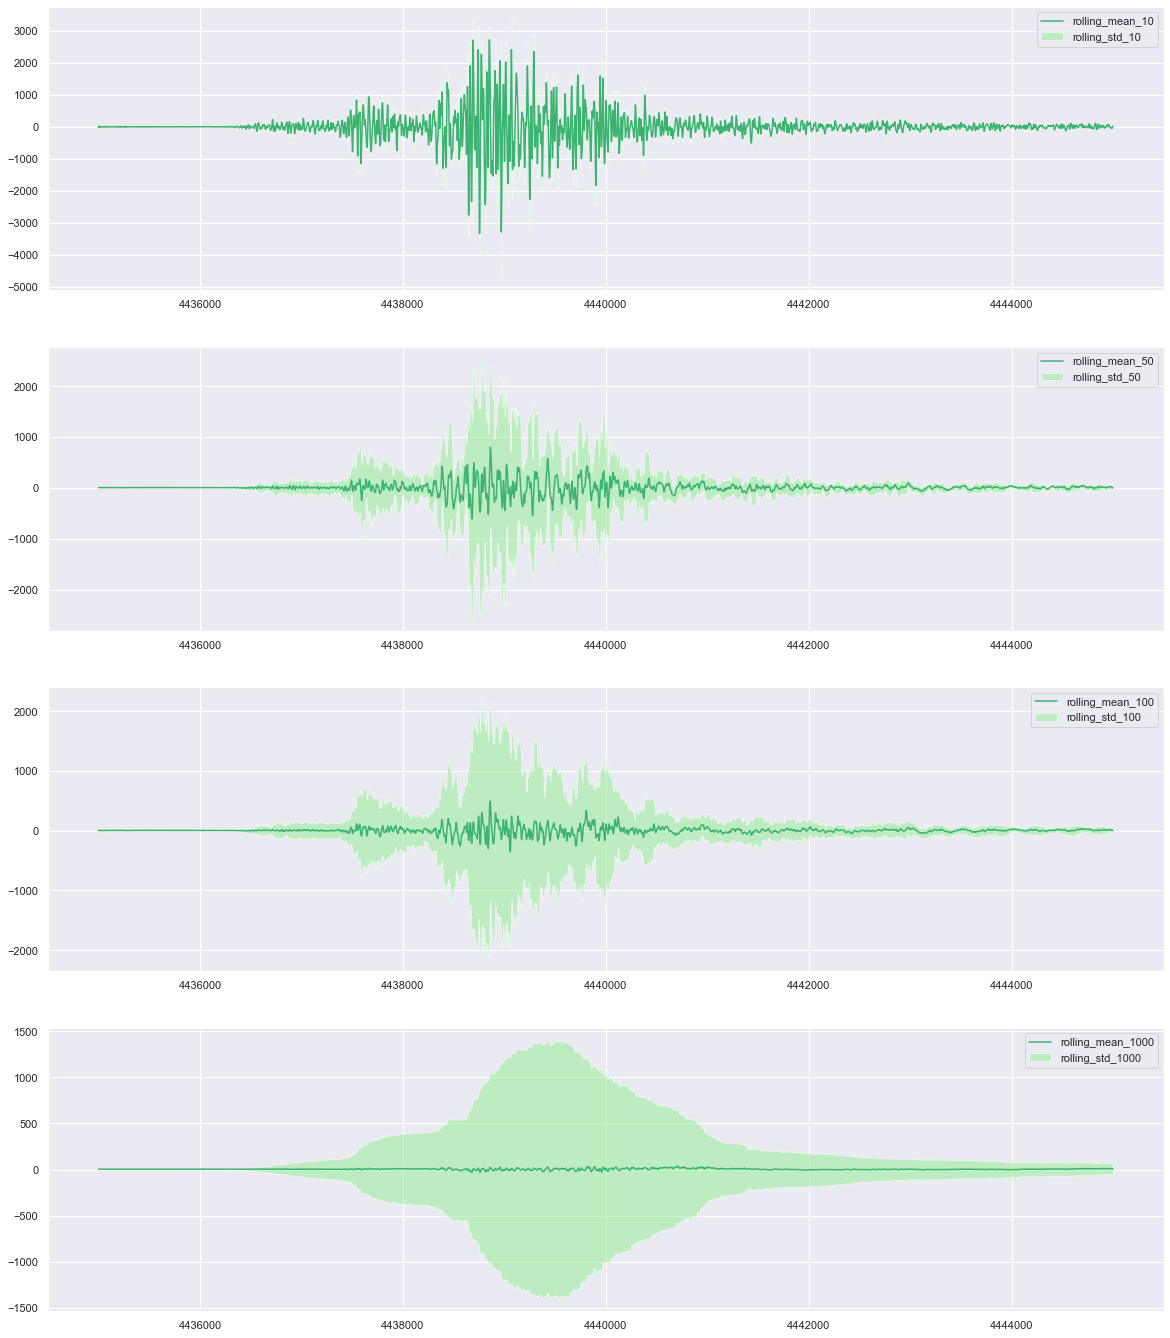

In [23]:
fig, ax = plt.subplots(len(window_sizes),1,figsize=(20,6*len(window_sizes)))

n = 0
for col in train.columns.values:
    if "rolling_" in col:
        if "mean" in col:
            mean_df = train.iloc[4435000:4445000][col]
            ax[n].plot(mean_df, label=col, color="mediumseagreen")
        if "std" in col:
            std = train.iloc[4435000:4445000][col].values
            ax[n].fill_between(mean_df.index.values,
                               mean_df.values-std, mean_df.values+std,
                               facecolor='lightgreen',
                               alpha = 0.5, label=col)
            ax[n].legend()
            n+=1

A window size of 50 looks good enough to cover most fluctuations in sufficient detail without averaging out important signals.

Now, that we have found a first choice for the window size (50), let's compute some basic rolling statistical features: mean, standard deviation, 25% quartile, 50% quartile (median), 75% quartile, interquartile range (75%-25%), min, max, skewness, and kurtosis.

In [24]:
train["rolling_q25"] = train.signal.rolling(window=50).quantile(0.25)
train["rolling_q75"] = train.signal.rolling(window=50).quantile(0.75)
train["rolling_q50"] = train.signal.rolling(window=50).quantile(0.5)
train["rolling_iqr"] = train.rolling_q75 - train.rolling_q25
train["rolling_min"] = train.signal.rolling(window=50).min()
train["rolling_max"] = train.signal.rolling(window=50).max()
train["rolling_skew"] = train.signal.rolling(window=50).skew()
train["rolling_kurt"] = train.signal.rolling(window=50).kurt()

This concludes my initial Exploratory Data Analysis.